In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121, MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD

In [2]:
# Veri organizasyonu
base_dir = './data'
source_with_mask = os.path.join(base_dir, 'with_mask')
source_without_mask = os.path.join(base_dir, 'without_mask')

subdirs = ['train', 'validation', 'test']
classes = ['with_mask', 'without_mask']

for subdir in subdirs:
    for class_name in classes:
        target_dir = os.path.join(base_dir, subdir, class_name)
        os.makedirs(target_dir, exist_ok=True)

In [3]:
def move_images(src_dir, dest_dir, class_name, percentage=0.8):
    all_images = [f for f in os.listdir(src_dir) if f.endswith('.jpg') or f.endswith('.png')]
    num_images = len(all_images)
    num_train = int(num_images * percentage)
    num_valid = num_test = int(num_images * (1 - percentage) / 2)
    
    random.shuffle(all_images)
    train_images = all_images[:num_train]
    valid_images = all_images[num_train:num_train+num_valid]
    test_images = all_images[num_train+num_valid:]
    
    def move_to_dir(images, target_dir):
        for img in images:
            src_path = os.path.join(src_dir, img)
            target_path = os.path.join(target_dir, img)
            shutil.move(src_path, target_path)
    
    move_to_dir(train_images, os.path.join(dest_dir, 'train', class_name))
    move_to_dir(valid_images, os.path.join(dest_dir, 'validation', class_name))
    move_to_dir(test_images, os.path.join(dest_dir, 'test', class_name))

In [4]:
# Veri artırma ve yükleme
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8,1.2],
    channel_shift_range=50,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    './data/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = valid_datagen.flow_from_directory(
    './data/validation',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 6042 images belonging to 2 classes.
Found 754 images belonging to 2 classes.


In [5]:
# Model oluşturma fonksiyonları
def build_densenet_model(input_shape, num_classes, fine_tune_at=100):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    output = layers.Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model, base_model

In [6]:
def build_mobilenet_model(input_shape, num_classes, fine_tune_at=100):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    output = layers.Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model, base_model

In [7]:
# İki aşamalı eğitim fonksiyonu
# ReduceLROnPlateau kullanarak başlangıç öğrenme oranını sabit bir değer olarak belirledik.
# reduceLROnPlateau validasyon kaybınına göre learning ratei dinamik olarak ayarlar
def train_model(model, base_model, train_generator, validation_generator):
    # İlk aşama: Yalnızca yeni katmanların eğitimi
    initial_learning_rate = 0.001
    optimizer = Adam(learning_rate=initial_learning_rate)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    history1 = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=50,
        callbacks=[early_stopping, reduce_lr]
    )
    
    # İkinci aşama: Fine-tuning
    base_model.trainable = True
    for layer in base_model.layers[:50]:
        layer.trainable = False
    
    model.compile(optimizer=Adam(learning_rate=1e-5),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    
    history2 = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=50,
        callbacks=[early_stopping, reduce_lr]
    )
    
    return history1, history2

# Modelleri eğit ve değerlendir
models = {
    'densenet': build_densenet_model((224, 224, 3), 2),
    'mobilenet': build_mobilenet_model((224, 224, 3), 2)
}

results = {}

for model_name, (model, base_model) in models.items():
    print(f"\nTraining {model_name}...")
    history1, history2 = train_model(model, base_model, train_generator, validation_generator)
    
    # Test değerlendirmesi
    test_generator = valid_datagen.flow_from_directory(
        './data/test',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=False
    )
    
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_generator.classes
    
    # Metrikleri hesapla
    fpr, tpr, _ = roc_curve(y_true, y_pred[:,1])
    roc_auc = auc(fpr, tpr)
    cm = confusion_matrix(y_true, y_pred_classes)
    report = classification_report(y_true, y_pred_classes, 
                                target_names=test_generator.class_indices.keys())
    
    results[model_name] = {
        'histories': (history1, history2),
        'roc': (fpr, tpr, roc_auc),
        'cm': cm,
        'report': report,
        'y_pred': y_pred,
        'y_true': y_true
    }


Training densenet...


C:\Users\besir\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
109/189 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - accuracy: 0.8795 - loss: 0.2405

C:\Users\besir\anaconda3\Lib\site-packages\PIL\Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


189/189 ━━━━━━━━━━━━━━━━━━━━ 446s 2s/step - accuracy: 0.9072 - loss: 0.1955 - val_accuracy: 0.9934 - val_loss: 0.0156 - learning_rate: 0.0010
Epoch 2/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 377s 2s/step - accuracy: 0.9721 - loss: 0.0752 - val_accuracy: 0.9920 - val_loss: 0.0279 - learning_rate: 0.0010
Epoch 3/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 375s 2s/step - accuracy: 0.9809 - loss: 0.0596 - val_accuracy: 0.9934 - val_loss: 0.0125 - learning_rate: 0.0010
Epoch 4/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 375s 2s/step - accuracy: 0.9791 - loss: 0.0580 - val_accuracy: 0.9947 - val_loss: 0.0124 - learning_rate: 0.0010
Epoch 5/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 376s 2s/step - accuracy: 0.9797 - loss: 0.0520 - val_accuracy: 0.9960 - val_loss: 0.0135 - learning_rate: 0.0010
Epoch 6/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 375s 2s/step - accuracy: 0.9836 - loss: 0.0480 - val_accuracy: 0.9947 - val_loss: 0.0125 - learning_rate: 0.0010
Epoch 7/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 379s 2s/step - accuracy: 0.9806 - loss: 0.0451 - val_

C:\Users\besir\anaconda3\Lib\site-packages\PIL\Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


189/189 ━━━━━━━━━━━━━━━━━━━━ 178s 919ms/step - accuracy: 0.9095 - loss: 0.2183 - val_accuracy: 0.9721 - val_loss: 0.0812 - learning_rate: 0.0010
Epoch 2/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 171s 902ms/step - accuracy: 0.9643 - loss: 0.1012 - val_accuracy: 0.9735 - val_loss: 0.0691 - learning_rate: 0.0010
Epoch 3/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 172s 908ms/step - accuracy: 0.9688 - loss: 0.0802 - val_accuracy: 0.9775 - val_loss: 0.0549 - learning_rate: 0.0010
Epoch 4/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 171s 902ms/step - accuracy: 0.9700 - loss: 0.0876 - val_accuracy: 0.9775 - val_loss: 0.0687 - learning_rate: 0.0010
Epoch 5/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 170s 898ms/step - accuracy: 0.9753 - loss: 0.0616 - val_accuracy: 0.9775 - val_loss: 0.0539 - learning_rate: 0.0010
Epoch 6/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 168s 890ms/step - accuracy: 0.9771 - loss: 0.0582 - val_accuracy: 0.9775 - val_loss: 0.0513 - learning_rate: 0.0010
Epoch 7/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 169s 893ms/step - accuracy: 0.9785 

C:\Users\besir\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 665ms/step


In [8]:
# Sonuçları görselleştir
def plot_training_history(histories, title):
    plt.figure(figsize=(15, 5))
    
    # İlk aşama
    plt.subplot(1, 2, 1)
    plt.plot(histories[0].history['accuracy'], label='Training Accuracy (Phase 1)')
    plt.plot(histories[0].history['val_accuracy'], label='Validation Accuracy (Phase 1)')
    plt.title(f'{title} - Phase 1')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # İkinci aşama
    plt.subplot(1, 2, 2)
    plt.plot(histories[1].history['accuracy'], label='Training Accuracy (Phase 2)')
    plt.plot(histories[1].history['val_accuracy'], label='Validation Accuracy (Phase 2)')
    plt.title(f'{title} - Phase 2')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [9]:
def plot_roc_curves():
    plt.figure(figsize=(10, 8))
    colors = ['blue', 'red']
    for (name, result), color in zip(results.items(), colors):
        fpr, tpr, roc_auc = result['roc']
        plt.plot(fpr, tpr, color=color, lw=2,
                label=f'{name} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend(loc='lower right')
    plt.show()

In [10]:
def plot_confusion_matrices():
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    for (name, result), ax in zip(results.items(), axes):
        sns.heatmap(result['cm'], annot=True, fmt='d', cmap='Blues', ax=ax,
                   xticklabels=test_generator.class_indices.keys(),
                   yticklabels=test_generator.class_indices.keys())
        ax.set_title(f'{name} Confusion Matrix')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
    plt.tight_layout()
    plt.show()

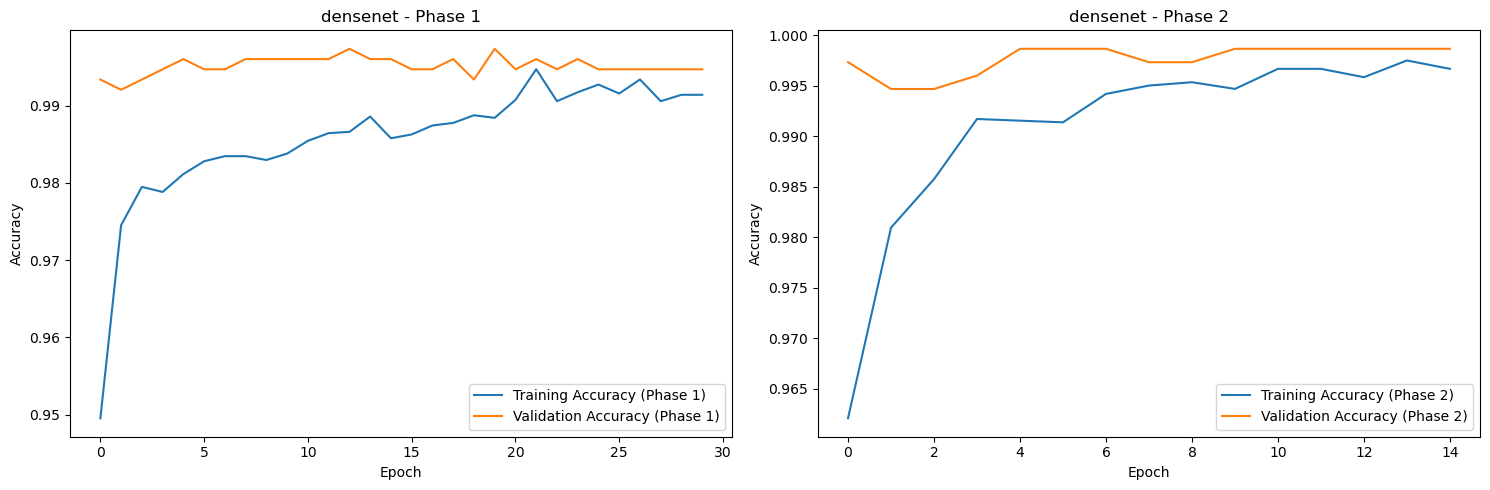


densenet Classification Report:
              precision    recall  f1-score   support

   with_mask       1.00      0.99      1.00       373
without_mask       0.99      1.00      1.00       384

    accuracy                           1.00       757
   macro avg       1.00      1.00      1.00       757
weighted avg       1.00      1.00      1.00       757



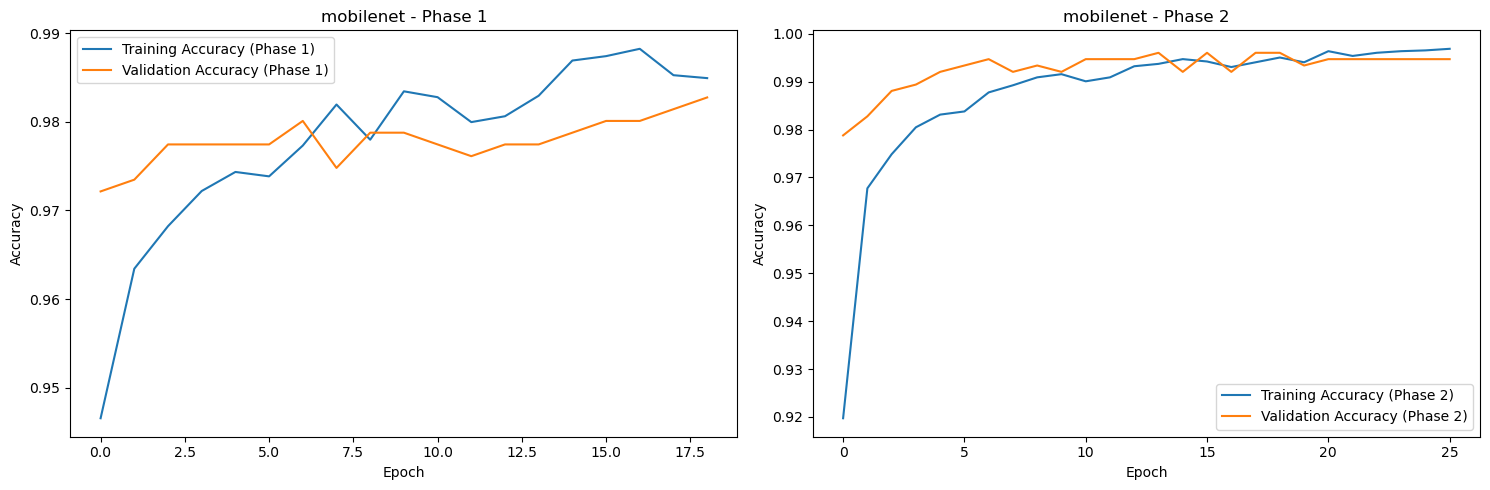


mobilenet Classification Report:
              precision    recall  f1-score   support

   with_mask       1.00      1.00      1.00       373
without_mask       1.00      1.00      1.00       384

    accuracy                           1.00       757
   macro avg       1.00      1.00      1.00       757
weighted avg       1.00      1.00      1.00       757



In [11]:
# Görselleştirmeleri göster
for name, result in results.items():
    plot_training_history(result['histories'], name)
    print(f"\n{name} Classification Report:")
    print(result['report'])

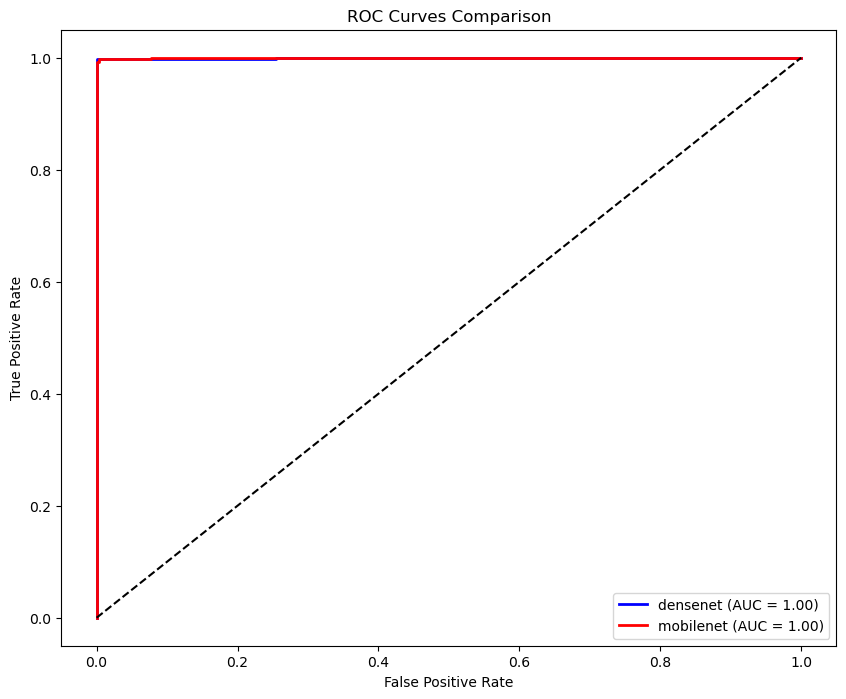

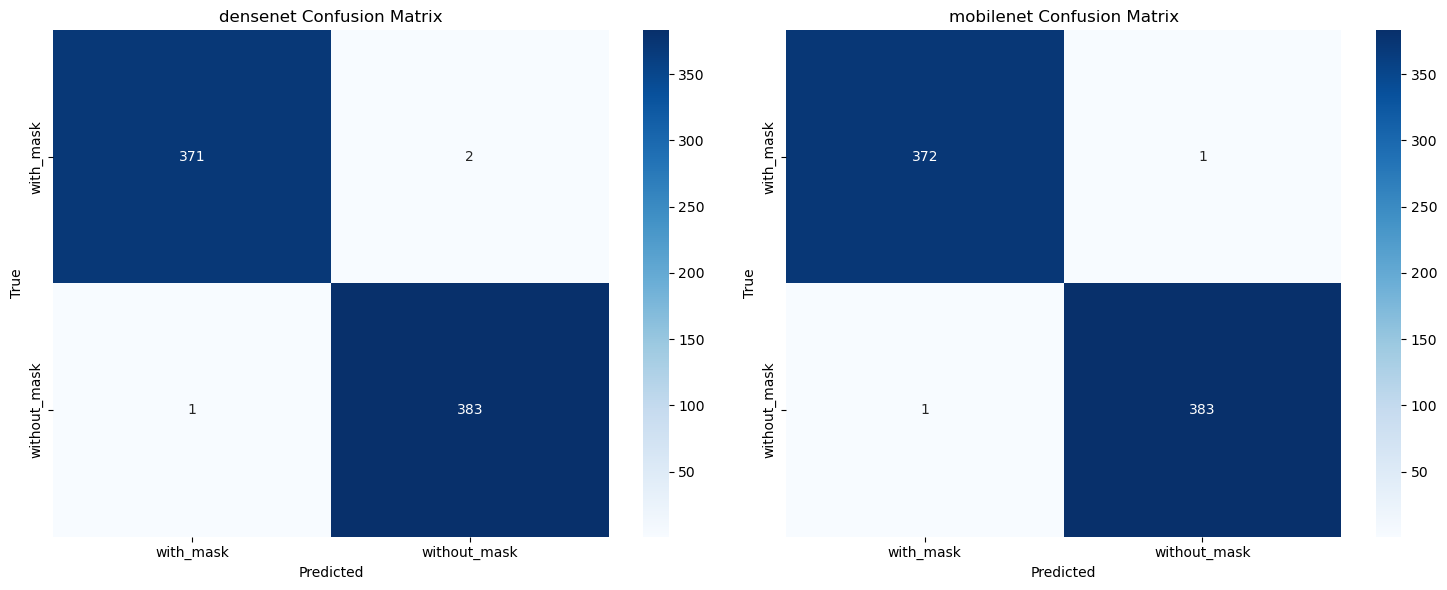

In [12]:
plot_roc_curves()
plot_confusion_matrices()